# Apriori Association Rule Mining on Manufacturing Defects

This notebook performs association rule mining using the Apriori algorithm to discover co-occurring patterns in defect types, severity, and inspection methods. It is part of a larger machine learning analysis on defect data, aligned with classification models for predicting severity.


In [2]:
# Import required libraries
%pip install mlxtend
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mlxtend
from mlxtend.frequent_patterns import apriori, association_rules
import missingno as msno



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Load dataset from KaggleHub
import kagglehub

path = kagglehub.dataset_download("fahmidachowdhury/manufacturing-defects")
file_path = f"{path}/defects_data.csv"
defects = pd.read_csv(file_path)

print(" Dataset loaded successfully:")
display(defects.head())

/usr/local/python/3.12.1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


 Dataset loaded successfully:


,defect_id,product_id,defect_type,defect_date,defect_location,severity,inspection_method,repair_cost
0,1,15,Structural,6/6/2024,Component,Minor,Visual Inspection,245.47
1,2,6,Functional,4/26/2024,Component,Minor,Visual Inspection,26.87
2,3,84,Structural,2/15/2024,Internal,Minor,Automated Testing,835.81
3,4,10,Functional,3/28/2024,Internal,Critical,Automated Testing,444.47
4,5,14,Cosmetic,4/26/2024,Component,Minor,Manual Testing,823.64


In [4]:
# Initial Data Overview
def initial_data_overview(df):
    print("Data Info:")
    print(df.info())
    print("\n Class Distribution in 'severity':")
    print(df['severity'].value_counts(normalize=True))
    display(df.describe())

initial_data_overview(defects)

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   defect_id          1000 non-null   int64  
 1   product_id         1000 non-null   int64  
 2   defect_type        1000 non-null   object 
 3   defect_date        1000 non-null   object 
 4   defect_location    1000 non-null   object 
 5   severity           1000 non-null   object 
 6   inspection_method  1000 non-null   object 
 7   repair_cost        1000 non-null   float64
dtypes: float64(1), int64(2), object(5)
memory usage: 62.6+ KB
None

 Class Distribution in 'severity':
severity
Minor       0.358
Critical    0.333
Moderate    0.309
Name: proportion, dtype: float64


,defect_id,product_id,repair_cost
count,1000.000000,1000.000000,1000.000000
mean,500.500000,50.837000,507.627150
std,288.819436,29.480935,289.623615
min,1.000000,1.000000,10.220000
25%,250.750000,26.000000,270.902500
50%,500.500000,51.000000,506.430000
75%,750.250000,77.000000,759.065000
max,1000.000000,100.000000,999.640000


Summary of Missing Values (by Column):
defect_id            0
product_id           0
defect_type          0
defect_date          0
defect_location      0
severity             0
inspection_method    0
repair_cost          0
dtype: int64

❓ Any Missing Values?  False


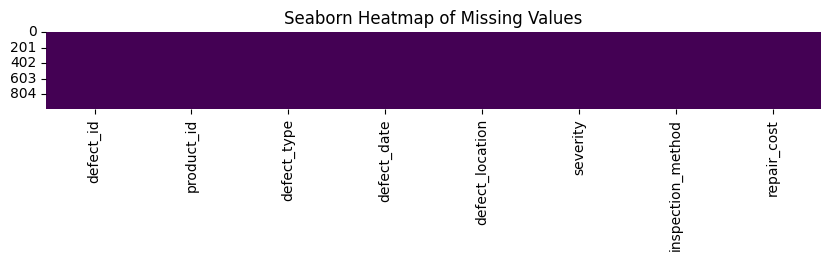

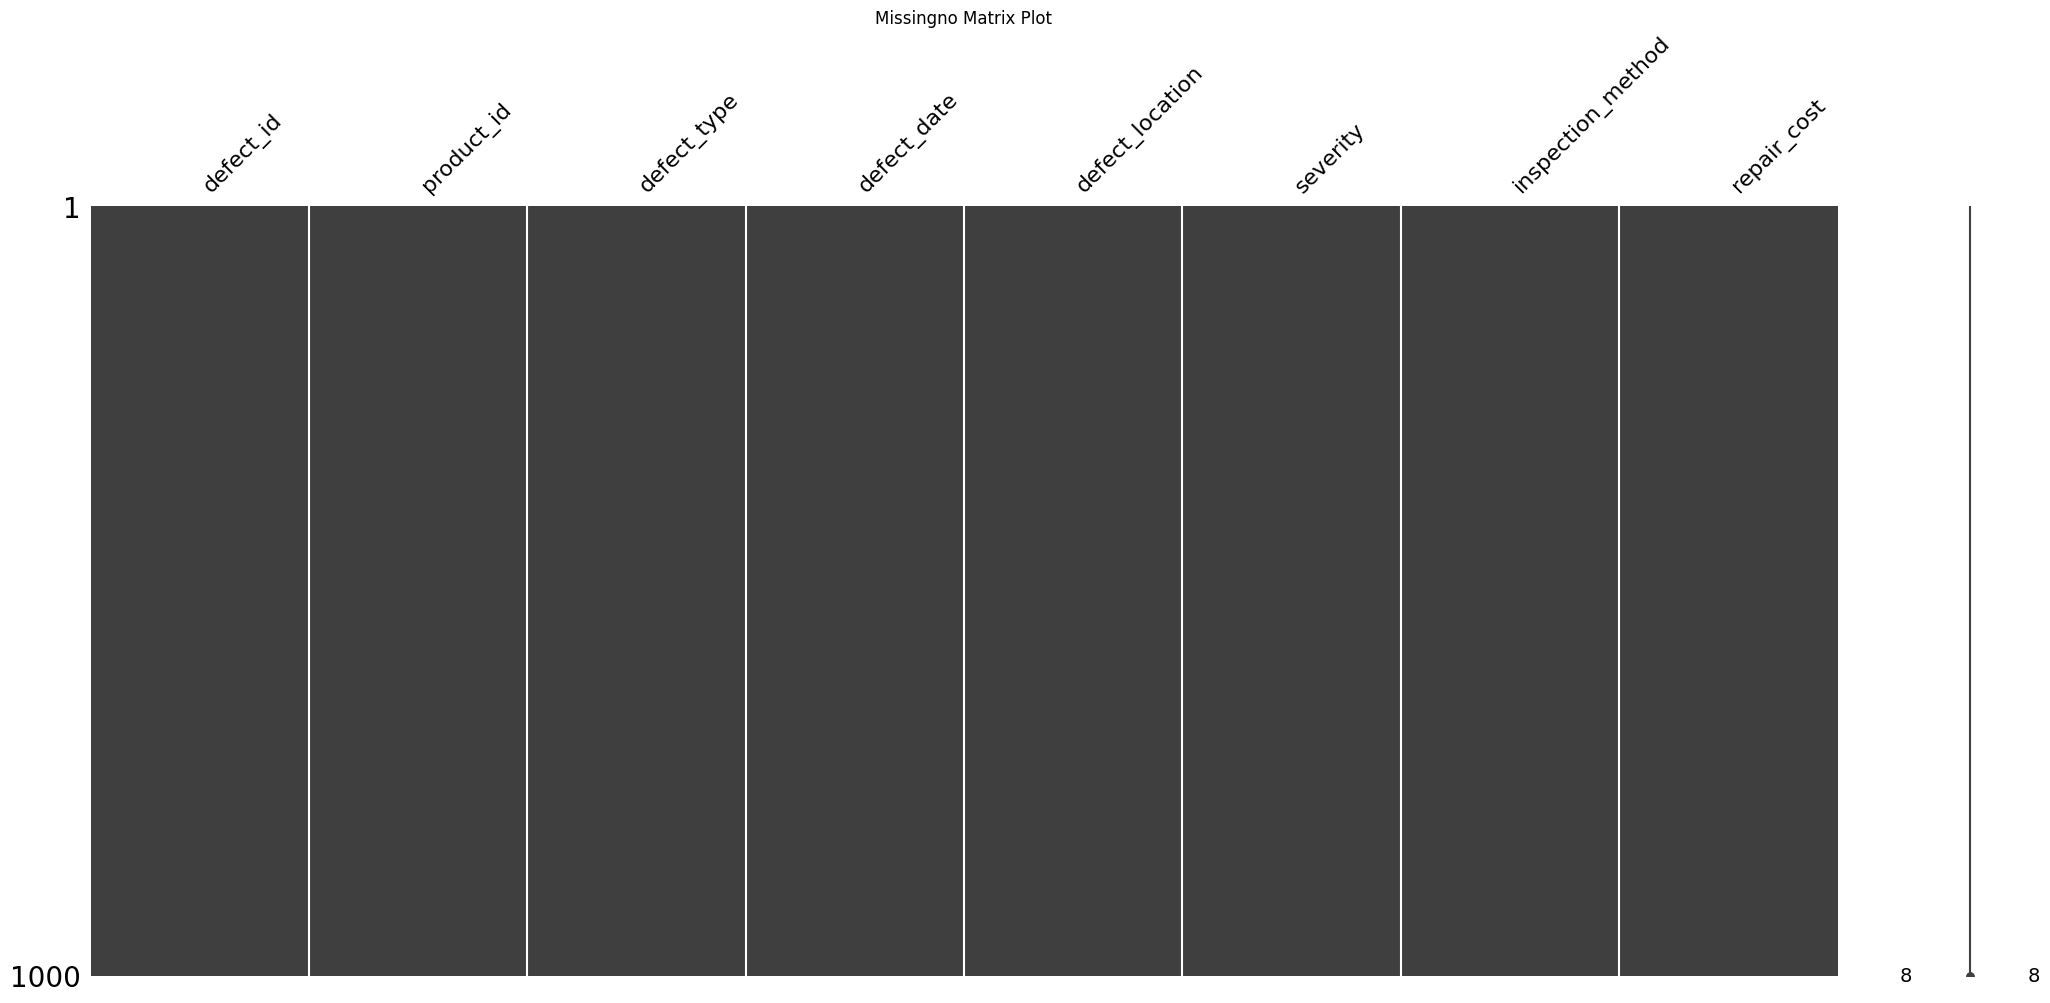

In [5]:
# Visualize Missing Values
def check_missing_values(df):
    print("Summary of Missing Values (by Column):")
    print(df.isnull().sum())
    print("\n❓ Any Missing Values? ", df.isnull().values.any())

    plt.figure(figsize=(10, 1))
    sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
    plt.title('Seaborn Heatmap of Missing Values')
    plt.show()

    msno.matrix(df)
    plt.title('Missingno Matrix Plot')
    plt.show()

check_missing_values(defects)

In [6]:
# Preprocessing for Apriori
# Drop continuous variables and convert categorical variables to dummies
defects_bool = defects.drop(columns=['defect_id', 'product_id', 'defect_date', 'repair_cost'])
defects_bool = pd.get_dummies(defects_bool, columns=['defect_type', 'defect_location', 'severity', 'inspection_method'])
display(defects_bool.head())

,defect_type_Cosmetic,defect_type_Functional,defect_type_Structural,defect_location_Component,defect_location_Internal,defect_location_Surface,severity_Critical,severity_Minor,severity_Moderate,inspection_method_Automated Testing,inspection_method_Manual Testing,inspection_method_Visual Inspection
0,False,False,True,True,False,False,False,True,False,False,False,True
1,False,True,False,True,False,False,False,True,False,False,False,True
2,False,False,True,False,True,False,False,True,False,True,False,False
3,False,True,False,False,True,False,True,False,False,True,False,False
4,True,False,False,True,False,False,False,True,False,False,True,False


In [7]:
# Run Apriori Algorithm
frequent_itemsets = apriori(defects_bool, min_support=0.1, use_colnames=True)
frequent_itemsets_sorted = frequent_itemsets.sort_values(by='support', ascending=False)
display(frequent_itemsets_sorted.head(10))

,support,itemsets
7,0.358,(severity_Minor)
5,0.353,(defect_location_Surface)
2,0.352,(defect_type_Structural)
10,0.352,(inspection_method_Manual Testing)
11,0.351,(inspection_method_Visual Inspection)
1,0.339,(defect_type_Functional)
6,0.333,(severity_Critical)
3,0.326,(defect_location_Component)
4,0.321,(defect_location_Internal)
8,0.309,(severity_Moderate)


In [8]:
# Generate Association Rules (Confidence & Lift)
rules_conf = association_rules(frequent_itemsets, metric='confidence', min_threshold=0.36)
rules_lift = association_rules(frequent_itemsets, metric='lift', min_threshold=1)

rules_filtered = rules_lift[(rules_lift['lift'] > 1.07) & (rules_lift['confidence'] > 0.37)]
display(rules_filtered.sort_values(by='lift', ascending=False).head(10))

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
18,(severity_Minor),(defect_type_Structural),0.358,0.352,0.139,0.388268,1.103035,1.0,0.012984,1.059288,0.145499,0.243433,0.055969,0.391577
19,(defect_type_Structural),(severity_Minor),0.352,0.358,0.139,0.394886,1.103035,1.0,0.012984,1.060958,0.144151,0.243433,0.057455,0.391577
47,(severity_Moderate),(inspection_method_Visual Inspection),0.309,0.351,0.119,0.385113,1.097189,1.0,0.010541,1.055479,0.128191,0.219963,0.052563,0.362072
0,(defect_type_Cosmetic),(defect_location_Surface),0.309,0.353,0.117,0.378641,1.072637,1.0,0.007923,1.041266,0.098000,0.214679,0.039630,0.355043
44,(inspection_method_Manual Testing),(severity_Minor),0.352,0.358,0.135,0.383523,1.071293,1.0,0.008984,1.041401,0.102698,0.234783,0.039755,0.380309
45,(severity_Minor),(inspection_method_Manual Testing),0.358,0.352,0.135,0.377095,1.071293,1.0,0.008984,1.040287,0.103658,0.234783,0.038727,0.380309


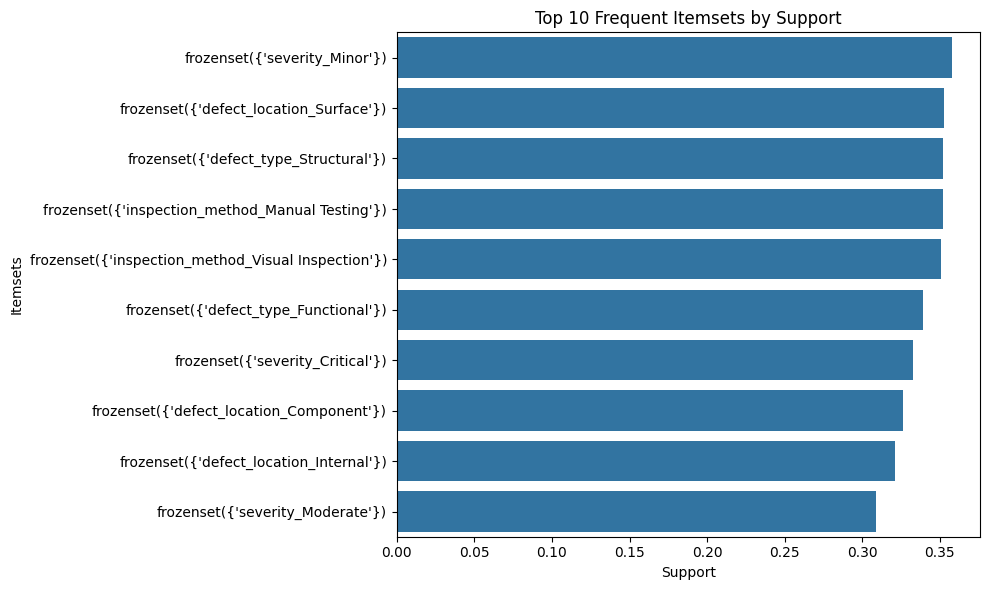

In [9]:
# Visualize Frequent Itemsets
plt.figure(figsize=(10, 6))
sns.barplot(data=frequent_itemsets_sorted.head(10), x='support', y='itemsets')
plt.title('Top 10 Frequent Itemsets by Support')
plt.xlabel('Support')
plt.ylabel('Itemsets')
frequent_itemsets_sorted['itemsets'] = frequent_itemsets_sorted['itemsets'].apply(lambda x: ', '.join(list(x)))
plt.tight_layout()
plt.show()

## Conclusion
The Apriori algorithm uncovered moderately strong associations among defect characteristics. While most rules had weak confidence and lift, the most frequent patterns suggest minor severity defects are often found using manual or visual inspection.

**Recommendations:**
- Consider combining association analysis with classification results to explore feature relationships.
- Additional granular features (e.g., operator ID, defect dimensions) could lead to stronger rules.

This analysis complements the supervised modeling work in the main notebook and helps build a fuller picture of defect behavior.